In [2]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline # make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [3]:
# semilla de aleatorización

seed = 99

### Cargar datos depurados

In [4]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [5]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [6]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

## 3.a Gradient Boosting

**Boosting**, de forma muy general, es crear y entrenar varios modelos, pero en lugar de entrenarlos por separado y "juntar" sus resultados para obtener la predicción final (bagging), en boosting se hace de forma secuencial, de forma que cada modelo se centra en corregir los errores de la predicción del modelo anterior. Y cuando se quiere predecir un nuevo valor (X_test), se pasa por la secuencia de modelos para obtener la predicción final.

**Gradient Boosting** es un tipo particular con árboles de decisión. Empezamos haciendo una predicción_0 de la variable objetivo. En regresión, se inicia con el valor promedio en y_train; en clasificación, se inicia con el valor promedio de la probabilidad de pertenencia a la clase de interés de la variable objetivo. Con esos valores predichos y con los valores reales (y_train), se calculan los errores (residuals_0) en la predicción (en la predicción de la variable obj, o bien de la probabilidad de pertenencia a la misma).

Se inicial el proceso: se construye un árbol que intenta predecir esos residuals_0, y ese árbol_1 predice los residuals_1, con los que se genera una nueva predicción_1, consistente en la predicción anterior (que en este primer paso, son esos promedios de la variab objetivo o de su probabilidad) + el residual predicho por el árbol para cada observación, ajustado con un learning rate:

prediction_1 = prediction_0 + learn_rate * residuals_1

Entonces, se repite el proceso: esa nueva predicción se compara con el valor real (y_train) y se obtienen nuevos residuals_2. Se hace otro árbol_2 que prediga estos residuals_2 para obtener la predicción_2:

prediction_2 = prediction_0 + learn_rate * residuals_1 + learn_rate * residuals_2

Y este proceso se repite hasta que se alcanza el número máximo de árboles estipulado, o los residuals alcancan un límite de tamaño mínimo (para evitar el sobreajuste).

Resumiendo, cada árbol intenta predecir los errores ('residuals') de la predicción del árbol anterior, ajustando con un learning rate, de tal manera que la predicción final consiste en ir recorriendo todos los árboles para ir modificando la predicción inicial (promedio) hasta alcanzar un buen modelo predictor/clasificador.

In [7]:
# Nota:
# En lugar de usar 'early stopping' para determinar el número ideal de árboles, lo haremos
# con validación cruzada del parám n_estimators.

# Pero sería interesante ver cómo hacerlo con early stopping (con train, validation & test)

_Nota: GradientBoostingClassifier() no tiene 'class_weight', así que comparamos entre usar SMOTE y no hacer nada (recuerda que hay argumentos a favor de no hacer nada ante el desbalanceo)_

In [8]:
# 1ª etapa (with all features)

import time
start_time = time.time()

# Algoritmo a probar

model = GradientBoostingClassifier(max_features='sqrt', # viene de la mejor arquitectura de árbol que ya hemos sacado
                                   min_samples_leaf=40,
                                   max_depth=5,
                                   random_state=seed)

    ## Posible early stopping: n_iter_no_change (...) --> no me voy a meter ahora en eso
    ## Posible pruning --> ni en eso

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

# Column transformer
col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']), # @@ necesario??
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

# Definir instancia SMOTENC
categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

# Pipeline 1
pipe = Pipeline([
#         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('algorithm', model)        
])

# Tuneado del modelo (malla de paráms)
parametros = {
    "algorithm__learning_rate": [0.1, 0.2, 0.3],
    "algorithm__subsample": [0.8, 0.9, 1] # si subsample < 1, bootstrapping --> "Stochastic Gradient Boosting"
}

# Repeated cross_val (stratified)
cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# combinamos todo
gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1')

# buscamos el mejor modelo
# opción a) sin resample y con class_weight='balanced':
# grid_model = gsearch.fit(X_train, y_train)

# opción b) con resample (SMOTE)
grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

Best CV score: 0.9990476174479157

Tiempo de ejecución: 453.0002484321594 segundos


In [9]:
# Mejor estimador
grid_model.best_estimator_.named_steps['algorithm']

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='sqrt',
                           min_samples_leaf=40, random_state=99, subsample=0.8)

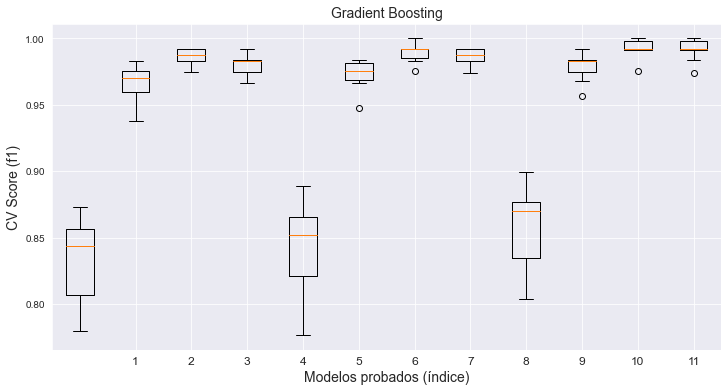


Tiempo de ejecución: 15.717294454574585 segundos


In [10]:
# 2ª etapa: boxplot para elegir el resto de paráms

# no podemos poner muchos paráms, o no veremos nada en los boxplots
# por eso aquí hay traer ya algunos paráms elegido

import time
start_time = time.time()

pipe_fs = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
        ('algorithm', grid_model.best_estimator_.named_steps['algorithm'])        
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__n_estimators": [20,30,40],
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Gradient Boosting', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [11]:
# Comparar mejores
print(grid_params[2])
print()
print(grid_params[6])
print()
print(grid_params[10])

{'algorithm__n_estimators': 20, 'feature_selection__k': 5}

{'algorithm__n_estimators': 30, 'feature_selection__k': 5}

{'algorithm__n_estimators': 40, 'feature_selection__k': 5}


In [20]:
# El mejor modelo es:
modelo_optimo = 2 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

Pipeline(steps=[('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop=['3-9']),
                                                  ['Orbit Uncertainity '
                                                   '(categ)']),
                                                 ('scaler', RobustScaler(),
                                                  ['Est Dia in M(max)',
                                                   'Relative Velocity km per '
                                                   'sec',
                                                   'Miss Dist.(Astronomical)',
                                                   'Minimum Orbit Intersection',
                                                   'Eccentricity',
                                                   'Semi Major Axis',
                                                   'Inclination',
                                                   'Asc Node Longitude...
                                                   'Distance_squared',
                                                   'Mean Anomaly_raiz2',
                                                   'Mean Motion_cuarta',
                                                   'Perihelion '
                                                   'Arg_squared'])])),
                ('polynomial',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('feature_selection', SelectKBest(k=5)),
                ('algorithm',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=5,
                                            max_features='sqrt',
                                            min_samples_leaf=40,
                                            n_estimators=20, random_state=99,
                                            subsample=0.8))])

In [21]:
selected_model.named_steps['algorithm'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 40,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'random_state': 99,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.993
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       1.00      0.99      0.99       151

    accuracy                           1.00       938
   macro avg       1.00      0.99      1.00       938
weighted avg       1.00      1.00      1.00       938



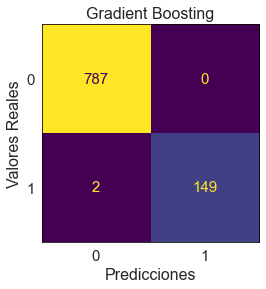

In [23]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Gradient Boosting', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

## Importancia de la variables

In [15]:
## Importancia de las variabs

importances = selected_model.named_steps['algorithm'].feature_importances_
feature_names = select_names

# comprobar qué opción estamos implementando:
print(len(importances))

5


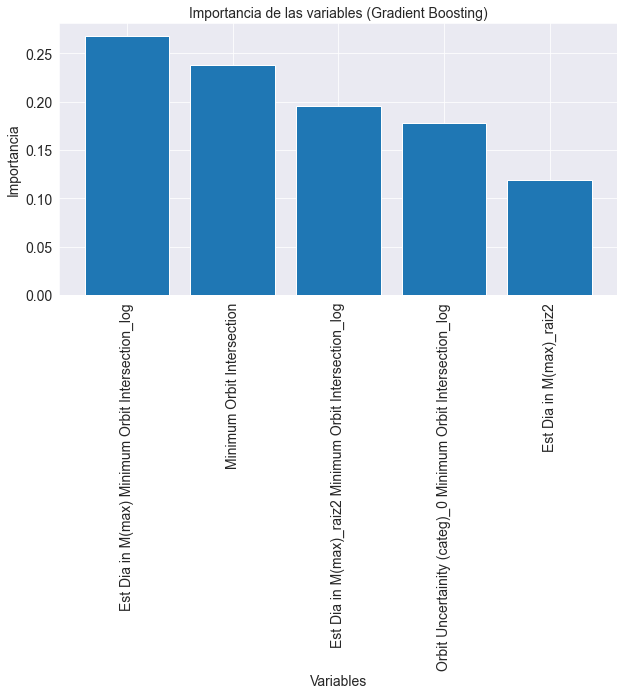

In [24]:
# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# (recortar el nombre de las variabs, sino es muy largo)
df_importances['Variable'] = df_importances['Variable'].replace(['scaler__', 'encoder__'], '', regex=True)

# Gráfico de barras
plt.figure(figsize=(10,5))
# Como son demasiadas variabs, mostramos solo las n mejores:
n = 10 # esto al final no lo he usado, pero se puede dejar así
plt.bar(df_importances['Variable'][0:n], df_importances['Importancia'][0:n])
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14) 
plt.title('Importancia de las variables (Gradient Boosting)', fontsize=14) 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()

In [25]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model5.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)